In [1]:
!del /Q utils\__pycache__

In [21]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
from utils.datasets import GhlKasperskyDataset, TepHarvardDataset, TepKasperskyDataset
from utils.watchmen import IsolatingWatchman
from utils.metrics import time_span_metrics
from utils.custom_plots import plot_stacked

## GHL

In [ ]:
ds = GhlKasperskyDataset()

### Without additional features

In [30]:
watchman = IsolatingWatchman(random_state=31)

ds.shake_not_stir(valid_test_ratio=0.4)

for train, _, _ in tqdm(ds.train_generator()):
    watchman.partial_fit(train, increment=1)

exam_list = pd.DataFrame(columns=['precision', 'recall', 'f1_score'])
for test, anomaly, info in tqdm(ds.test_generator()):
    detect = watchman.predict(test)
    exam_list.loc[info] = time_span_metrics(faults, detect)
    
exam_list.mean()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

precision    0.017957
recall       1.000000
f1_score     0.035280
dtype: float64

In [97]:
# plot_stacked(test, faults=faults)

### First and second derivatives

In [112]:
def add_derivatives(data: pd.DataFrame) -> pd.DataFrame:
    diff1 = data.diff()
    diff1.columns = data.columns + '_d1'
    diff2 = diff1.diff()
    diff2.columns = data.columns + '_d2'
    return pd.concat([data, diff1, diff2], axis=1).fillna(0)

In [113]:
watchman = IsolatingWatchman(random_state=31)

ds.shake_not_stir(valid_test_ratio=0.4)

for train, _, _ in tqdm(ds.train_generator()):
    train = add_derivatives(train)
    watchman.partial_fit(train, increment=1)

exam_list = pd.DataFrame(columns=['precision', 'recall', 'f1_score'])
for test, anomaly, info in tqdm(ds.test_generator()):
    test = add_derivatives(test)
    detect = watchman.predict(test)
    exam_list.loc[info] = time_span_metrics(faults, detect)
    
exam_list.mean()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

precision    0.017217
recall       0.862069
f1_score     0.033759
dtype: float64

### EWMA

In [149]:
ti_ewma = '5 min'

In [150]:
watchman = IsolatingWatchman(random_state=31)

ds.shake_not_stir(valid_test_ratio=0.4)

for train, _, _ in tqdm(ds.train_generator()):
    train = train.ewm(halflife=ti_ewma, times=train.index).mean()
    watchman.partial_fit(train, increment=1)

exam_list = pd.DataFrame(columns=['precision', 'recall', 'f1_score'])
for test, anomaly, info in tqdm(ds.test_generator()):
    test = test.ewm(halflife=ti_ewma, times=test.index).mean()
    detect = watchman.predict(test)
    exam_list.loc[info] = time_span_metrics(faults, detect)
    
exam_list.mean()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

precision    0.017893
recall       0.905172
f1_score     0.035092
dtype: float64

### With Fourier features

In [32]:
from numpy.fft import rfft

In [59]:
train.select_dtypes(include='float').shape

(1001, 7)

<AxesSubplot:>

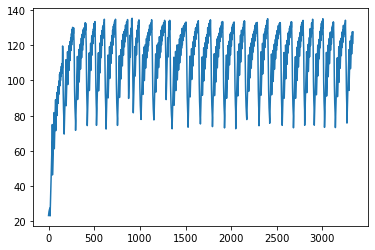

In [100]:
pd.Series(data=abs(rfft(test, n=15))[:, 2]).plot()

In [33]:
ht_temp = valid['ht_temp_gc'].iloc[:15].copy()

In [34]:
np.real(rfft(ht_temp.values))

array([211.44204712,  -6.63747415,  -4.33507715,  -3.90075559,
        -3.75032842,  -3.68312073,  -3.65117006,  -3.63814323])

In [35]:
np.imag(rfft(ht_temp.values))

array([ 0.        , 15.87164652,  7.77735764,  4.79000037,  3.13859762,
        2.01433893,  1.1339696 ,  0.36685355])

In [36]:
abs(rfft(ht_temp.values))

array([211.44204712,  17.20363992,   8.90394215,   6.1773779 ,
         4.89037405,   4.19796851,   3.82320937,   3.65659236])

In [25]:
np.angle(rfft(ht_temp.values))

array([0.       , 1.9668906, 2.079301 , 2.2542286, 2.4447615, 2.6411242,
       2.84046  , 3.041097 ], dtype=float32)

In [26]:
np.sin(np.angle(rfft(ht_temp.values)))

array([0.        , 0.92257494, 0.87347347, 0.77540994, 0.6417908 ,
       0.47983658, 0.296602  , 0.10032666], dtype=float32)

In [27]:
np.cos(np.angle(rfft(ht_temp.values)))

array([ 1.        , -0.38581795, -0.48687178, -0.63145816, -0.76687974,
       -0.8773579 , -0.9550012 , -0.9949545 ], dtype=float32)

In [5]:
watchman = IsolatingWatchman(random_state=31)

In [6]:
train_gen = ds.train_generator()
for train, _, _ in tqdm(train_gen, total=1):
    watchman.partial_fit(train)

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
watchman

IsolatingWatchman(n_trees=17)

In [8]:
valid_gen = ds.valid_generator()
examine_list = pd.DataFrame(columns=['precision', 'recall', 'f1_score'], dtype='float')
for valid, faults, info in tqdm(valid_gen, total=19):
    detect = watchman.predict(valid)
    examine_list.loc[info] = time_span_metrics(faults, detect)
#     if max(faults) and max(detect):
#         plot_stacked(data,
#                      title=info,
#                      group='value_unit',
#                      faults=faults,
#                      detect=detect,
#                     )

  0%|          | 0/19 [00:00<?, ?it/s]

In [9]:
examine_list.mean()

precision    0.013455
recall       1.000000
f1_score     0.026500
dtype: float64

In [ ]:
stop

## TEP Harvard

In [10]:
ds = TepHarvardDataset()
ds.shake_not_stir(valid_test_ratio=0.5, balanced_test=True)

In [11]:
watchman = IsolatingWatchman(random_state=31)

In [12]:
train_gen = ds.train_generator()
for train, _, _ in tqdm(train_gen, total=500):
    watchman.partial_fit(train)

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
watchman

IsolatingWatchman(n_trees=500)

In [14]:
valid_gen = ds.valid_generator()
examine_list = pd.DataFrame(columns=['precision', 'recall', 'f1_score'], dtype='float')
for valid, faults, info in tqdm(valid_gen, total=500):
    detect = watchman.predict(valid)
    examine_list.loc[info] = time_span_metrics(faults, detect)
#     if max(faults) and max(detect):
#         plot_stacked(data,
#                      title=info,
#                      group='value_unit',
#                      faults=faults,
#                      detect=detect,
#                     )

  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
examine_list.mean()

precision    1.000000
recall       0.505437
f1_score     0.589816
dtype: float64

## TEP Kaspersky

In [16]:
ds = TepKasperskyDataset()
ds.shake_not_stir(valid_test_ratio=0.4)

In [17]:
watchman = IsolatingWatchman(random_state=31, max_samples=1024)

In [18]:
watchman.forest

IsolationForest(max_samples=2048, n_estimators=0, n_jobs=-1, random_state=31,
                warm_start=True)

In [19]:
train_gen = ds.train_generator()
for train, _, _ in tqdm(train_gen, total=400):
    watchman.partial_fit(train, increment=1)

  0%|          | 0/400 [00:00<?, ?it/s]

In [20]:
watchman

IsolatingWatchman(n_trees=400)

In [21]:
valid_gen = ds.valid_generator()
examine_list = pd.DataFrame(columns=['precision', 'recall', 'f1_score'], dtype='float')
for valid, faults, info in tqdm(valid_gen, total=115):
    detect = watchman.predict(valid)
    examine_list.loc[info] = time_span_metrics(faults, detect)
#     if max(faults) and max(detect):
#         plot_stacked(data,
#                      title=info,
#                      group='value_unit',
#                      faults=faults,
#                      detect=detect,
#                     )

  0%|          | 0/115 [00:00<?, ?it/s]

In [22]:
examine_list.mean()

precision    0.084068
recall       1.000000
f1_score     0.128973
dtype: float64